In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('processed_train.csv')
pd.options.display.max_columns = 500
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,Platform_windows2016,Platform_windows7,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,171,0.500248,17134,256,0.522569,0.531303,0.514613,1.0,0,0.0,137.0,0.481757,1.0,1.0,0.523297,2668.0,9124.0,4.0,5.0,2341.0,476940.0,0.508330,299451.0,0,4096.0,0.525667,18.9,1440.0,900.0,0.525853,4.294967e+09,0.564357,0.524112,17134,165,0.513553,0.513910,0.524273,26.0,119,0.497938,0,0.492479,0.0,0.501748,628.0,36144.0,0,0.0,0,0,0.0,0.0,10.0,0,0,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,0.500248,17134,256,0.522569,0.531303,0.514613,1.0,0,0.0,137.0,0.481757,1.0,1.0,0.503060,2668.0,91656.0,4.0,5.0,2405.0,476940.0,0.508330,102385.0,0,4096.0,0.501220,13.9,1366.0,768.0,0.502902,1.000000e+00,0.529205,0.524112,17134,1,0.513553,0.513910,0.522071,8.0,31,0.497938,0,0.492479,0.0,0.495390,628.0,57858.0,0,0.0,0,0,0.0,0.0,8.0,0,0,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,0.500248,17134,768,0.522569,0.531303,0.492088,1.0,0,0.0,137.0,0.438313,1.0,1.0,0.523297,4909.0,317701.0,4.0,5.0,1972.0,114473.0,0.495242,113907.0,0,4096.0,0.525667,21.5,1920.0,1080.0,0.525853,4.294967e+09,0.564357,0.524112,17134,165,0.469357,0.469351,0.524273,7.0,30,0.517675,0,0.515559,0.0,0.501748,142.0,52682.0,0,0.0,0,0,0.0,0.0,3.0,0,0,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,150323.0,27.0,126.0,124,0.500248,14393,768,0.462186,0.502994,0.492088,1.0,0,0.0,94.0,0.438313,1.0,1.0,0.503060,5682.0,338896.0,2.0,5.0,3381.0,305245.0,0.508330,290807.0,1,4096.0,0.501220,15.5,1366.0,768.0,0.502902,0.000000e+00,0.492216,0.463520,14393,0,0.469357,0.469351,0.477921,18.0,72,0.517675,0,0.492479,0.0,0.501748,512.0,63122.0,0,0.0,0,0,0.0,0.0,15.0,0,0,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,155006.0,27.0,205.0,172,0.500248,17134,256,0.522569,0.531303,0.514613,1.0,0,0.0,137.0,0.438313,1.0,1.0,0.503060,2206.0,240688.0,4.0,5.0,2836.0,305245.0,0.508330,303892.0,0,4096.0,0.501220,15.6,1920.0,1080.0,0.502902,0.000000e+00,0.469380,0.524112,17134,254,0.513553,0.513910,0.480763,27.0,120,0.517675,0,0.492479,0.0,0.501748,500.0,15510.0,0,0.0,0,0,0.0,0.0,15.0,0,0,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here

# построим модель SVM
pipe_svm = Pipeline([('scaler_svm', MinMaxScaler()),
                     ("SVM", LinearSVC())
                    ])
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('scaler_svm', MinMaxScaler()), ('SVM', LinearSVC())])

In [10]:
### Обучим LogisticRegression
import datetime
begin_time_logreg = datetime.datetime.now()
pipe_lr = Pipeline([('scaler_logreg', MinMaxScaler()),
                    ("LogReg", LogisticRegression())
                   ])
pipe_lr.fit(X_train, y_train)
end_time_logreg = datetime.datetime.now()

print(f"Время обучения: {end_time_logreg - begin_time_logreg}")

Время обучения: 0:00:01.933146


In [14]:
print(f"Score LogReg модели / Score SVM модели : {pipe_lr.score(X_test, y_test):.3f}, {pipe_svm.score(X_test, y_test):.3f}")

Score LogReg модели / Score SVM модели : 0.843, 0.840


Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

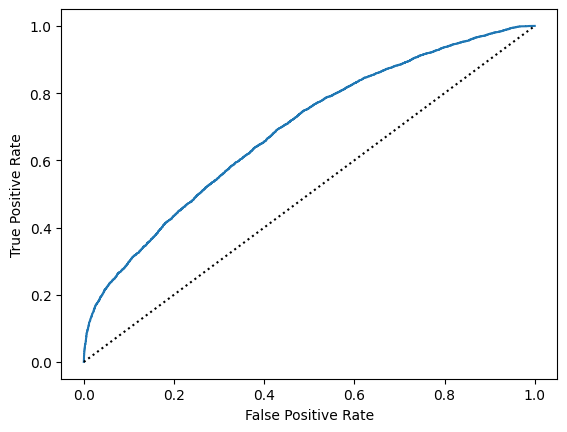

In [24]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr_lr, tpr=tpr_lr).plot()

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

In [36]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here
def sigmoid(output):
    return 1 / (1 + np.exp(-output))

pred_prob = sigmoid(pipe_svm.decision_function(X_test))

min(pred_prob), max(pred_prob)

(0.1467369654427862, 0.6454487078026243)

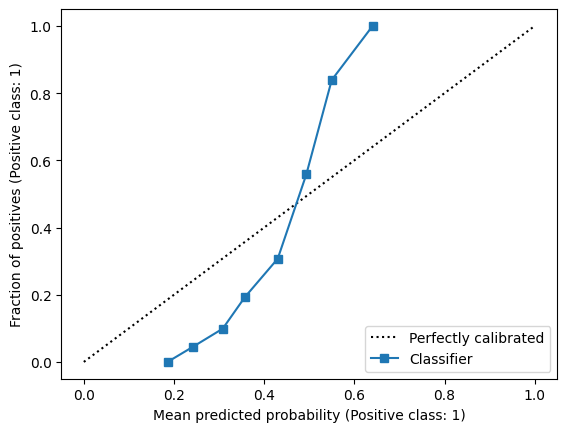

In [40]:
# нарисуем ROC кривую для SVM после преобразований выше


In [46]:
### найдем fpr_svm и tpr_svm для подсчета AUC с помощью roc_curve подав на вход вычисленный выше pred_prob
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, pred_prob)

In [49]:
from sklearn.metrics import auc 

### Your code is here
print(f"AUC LR / SVM: {auc(fpr_lr, tpr_lr):.3f},{auc(fpr_svm, tpr_svm):.3f} ")


AUC LR / SVM: 0.689,0.688 


Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

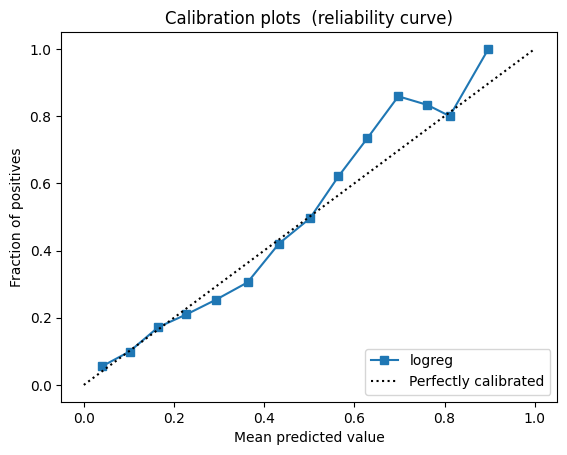

In [33]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here
### Предсказания модели на тесте и соответствующая калибровочная кривая
from sklearn.calibration import calibration_curve

prob_pos = pipe_lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=15)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.show()



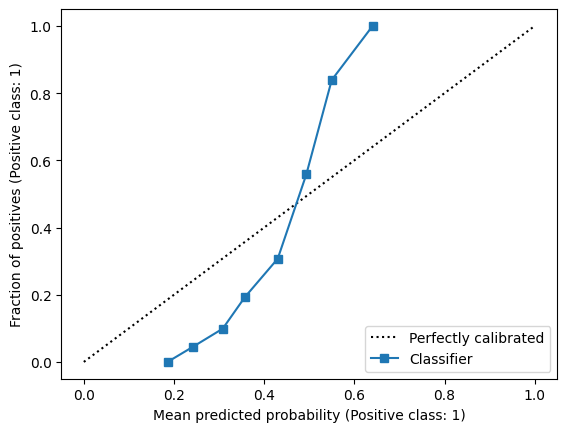

In [50]:
### калибровочная кривая SVM
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_predictions(y_test, pred_prob, n_bins=15)



**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [51]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here
calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')
calibration.fit(X_train, y_train)

calibrated_probs = calibration.predict_proba(X_test)[:, 1]

calibrated_probs


array([0.19971249, 0.1467314 , 0.11986854, ..., 0.11302157, 0.17690739,
       0.10944458])

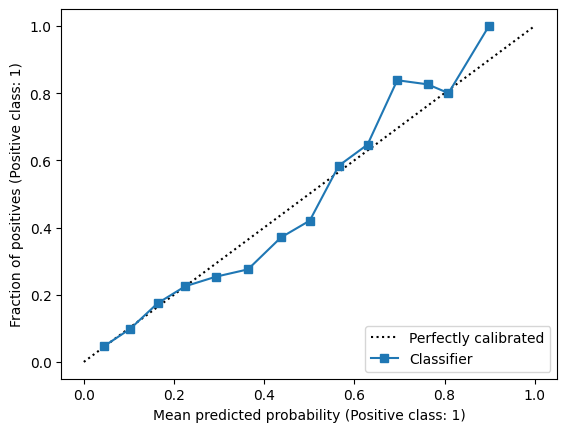

In [52]:
### Новая кривая

### Your code is here
CalibrationDisplay.from_predictions(y_test, calibrated_probs, n_bins=15)